# Imports and Data Loading

In [56]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy.io as sio
from scipy.ndimage import gaussian_filter, binary_opening, binary_closing
from scipy.signal import find_peaks, butter, filtfilt
from skimage.filters import threshold_otsu
from skimage.measure import find_contours

In [57]:
data = sio.loadmat('./data/GAIT080624-01/gait_recording_080624_walk2.mat')
insoleAll_l = data['insoleAll_l'].astype(np.float64)
insoleAll_r = data['insoleAll_r'].astype(np.float64)
t_insole_l = data['t_insole_l'].astype(np.float64)
t_insole_r = data['t_insole_r'].astype(np.float64)

In [58]:
# Computing averages
avg_l = np.mean(insoleAll_l, axis=0)  # Result is 1 x 1024
avg_r = np.mean(insoleAll_r, axis=0)  # Result is 1 x 1024

# Reshape the averages into 64 x 16 images
img_avg_l = np.reshape(avg_l, (64, 16), order='F')
img_avg_r = np.reshape(avg_r, (64, 16), order='F')

# Flip right insole left-right and flip top half of both up-down
img_avg_r = np.fliplr(img_avg_r)
img_avg_l[:32, :] = np.flipud(img_avg_l[:32, :])
img_avg_r[:32, :] = np.flipud(img_avg_r[:32, :])

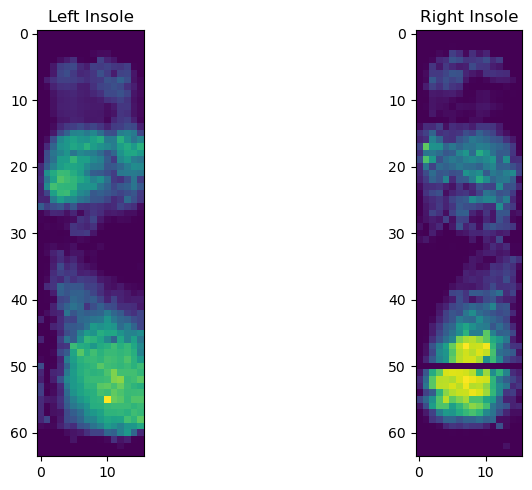

In [59]:
# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")

# Right Insole Plot
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

plt.tight_layout()
plt.show()

# Creating outline of foot

In [102]:
tunable_params = {
    'insole_dims': (64, 16),
    'pad_width': 1,
    'sigma': 1.0,
    'morph_size': 3,
    # Fixed threshold for the mask:
    'foot_mask_threshold': 0,
    # Toggle for Gaussian smoothing:
    'apply_gaussian': False,  
    'aggregation_window': 10,
    'lowpass_cutoff': 8,
    'fs': 50,
    'filter_order': 4,
    'h_th_r': 30,
    't_th_r': 30,
    'h_th_l': 30,
    't_th_l': 30,
    'strike_th_l': 2,
    'strike_th_r': 2,
    'animation_interval': 100,
}

In [97]:
def extract_foot_mask(pressure_data, threshold=None, sigma=tunable_params['sigma'], 
                        morph_size=tunable_params['morph_size'], pad_width=tunable_params['pad_width']):
    """
    Extracts a binary foot mask from a pressure data array.
    If smoothing is disabled, the raw padded data is used.
    Uses a tunable threshold value (defaulting to tunable_params['foot_mask_threshold'])
    """
    padded_data = np.pad(pressure_data, pad_width=pad_width, mode='edge')
    
    # Apply Gaussian smoothing if enabled; otherwise, use the raw padded data.
    if tunable_params.get('apply_gaussian', True):
        processed_data = gaussian_filter(padded_data, sigma=sigma)
    else:
        processed_data = padded_data

    # Use the tunable threshold value if none is provided.
    if threshold is None:
        threshold = tunable_params.get('foot_mask_threshold', 0)

    binary_mask = processed_data > threshold
    structure = np.ones((morph_size, morph_size))
    cleaned_mask = binary_opening(binary_mask, structure=structure)
    cleaned_mask = binary_closing(cleaned_mask, structure=structure)
    mask = cleaned_mask[pad_width:-pad_width, pad_width:-pad_width]
    return mask

def aggregate_mask_central_window(insole_data, step, dim=tunable_params['insole_dims'], 
                                  window=tunable_params['aggregation_window'], threshold=None, 
                                  sigma=tunable_params['sigma'], morph_size=tunable_params['morph_size'], 
                                  pad_width=tunable_params['pad_width']):
    """
    Aggregates binary masks for frames in a window of +/- 'window' frames 
    around the mid-point (between strike and off).
    """
    start_idx = step['strike'][0]
    off_idx = step['off'][0] if step['off'] else (step['strike'][1] if len(step['strike']) > 1 else start_idx)
    mid_idx = (start_idx + off_idx) // 2
    window_start = max(start_idx, mid_idx - window)
    window_end = min(off_idx, mid_idx + window)
    agg_mask = np.zeros(dim, dtype=bool)
    for i in range(window_start, window_end + 1):
        frame = insole_data[i, :].reshape(dim, order='F')
        mask = extract_foot_mask(frame, threshold=threshold, sigma=sigma,
                         morph_size=morph_size, pad_width=pad_width)
        agg_mask = np.logical_or(agg_mask, mask)
    return agg_mask

def butter_lowpass_filter(data, cutoff=tunable_params['lowpass_cutoff'], fs=tunable_params['fs'], order=tunable_params['filter_order']):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

def reshape_insole_grid(data, dims=tunable_params['insole_dims']):
    num_frames = data.shape[0]
    reshaped_data = np.empty((num_frames, dims[0], dims[1]), dtype=data.dtype)
    for i in range(num_frames):
        # Reshape using Fortran-order equivalent and flip the top half.
        frame = data[i].reshape(dims[1], dims[0]).T.copy()
        frame[:32, :] = np.flipud(frame[:32, :])
        reshaped_data[i] = frame
    return reshaped_data

def segment_insole_data(insole_data):
    toe_region = insole_data[:, :15, :]
    forefoot_region = insole_data[:, 15:33, :]
    midfoot_region = insole_data[:, 33:47, :]
    heel_region = insole_data[:, 47:, :]
    return heel_region, midfoot_region, forefoot_region, toe_region

def gait_segmentation(insole, h_th, t_th):
    insole = reshape_insole_grid(insole)
    heel_region, midfoot_region, forefoot_region, toe_region = segment_insole_data(insole)
    p_heel = np.mean(heel_region, axis=(1, 2))
    p_toe = np.mean(toe_region, axis=(1, 2))
    p_forefoot = np.mean(forefoot_region, axis=(1, 2))
    p_heel_filtered = butter_lowpass_filter(p_heel)
    p_fore_filtered = butter_lowpass_filter(p_toe + p_forefoot)
    p_heel_derivative = np.gradient(p_heel_filtered)
    p_fore_derivative = np.gradient(p_fore_filtered)
    hc_indices, _ = find_peaks(p_heel_derivative, height=h_th, distance=20)
    to_indices, _ = find_peaks(-p_fore_derivative, height=t_th, distance=20)
    return hc_indices, to_indices

def get_gait_event_masks(insole_r, insole_l, t_r, t_l, thresholds, dim=tunable_params['insole_dims']):
    """
    Extracts gait event timestamps (strike and off) and aggregates the foot outline mask
    for each step.
    """
    h_th_r, t_th_r, h_th_l, t_th_l, strike_th_l, strike_th_r = thresholds
    
    # --- Process Right Foot ---
    hc_indices_r, to_indices_r = gait_segmentation(insole_r, h_th_r, t_th_r)
    strike_r = hc_indices_r
    off_r = to_indices_r
    steps_r = []
    for i in range(len(strike_r) - 1):
        start, end = strike_r[i], strike_r[i + 1]
        if t_r[end] - t_r[start] > strike_th_r:
            continue
        step_off = [o for o in off_r if start <= o <= end]
        steps_r.append({'strike': [start, end], 'off': step_off})
    foot_mask_r = [aggregate_mask_central_window(insole_r, step, dim=dim)
                   for step in steps_r]
    
    # --- Process Left Foot ---
    hc_indices_l, to_indices_l = gait_segmentation(insole_l, h_th_l, t_th_l)
    strike_l = hc_indices_l
    off_l = to_indices_l
    steps_l = []
    for i in range(len(strike_l) - 1):
        start, end = strike_l[i], strike_l[i + 1]
        if t_l[end] - t_l[start] > strike_th_l:
            continue
        step_off = [o for o in off_l if start <= o <= end]
        steps_l.append({'strike': [start, end], 'off': step_off})
    foot_mask_l = [aggregate_mask_central_window(insole_l, step, dim=dim)
                   for step in steps_l]
    
    return {
        'steps_r': steps_r,
        'steps_l': steps_l,
        'foot_mask_r': foot_mask_r,
        'foot_mask_l': foot_mask_l,
    }

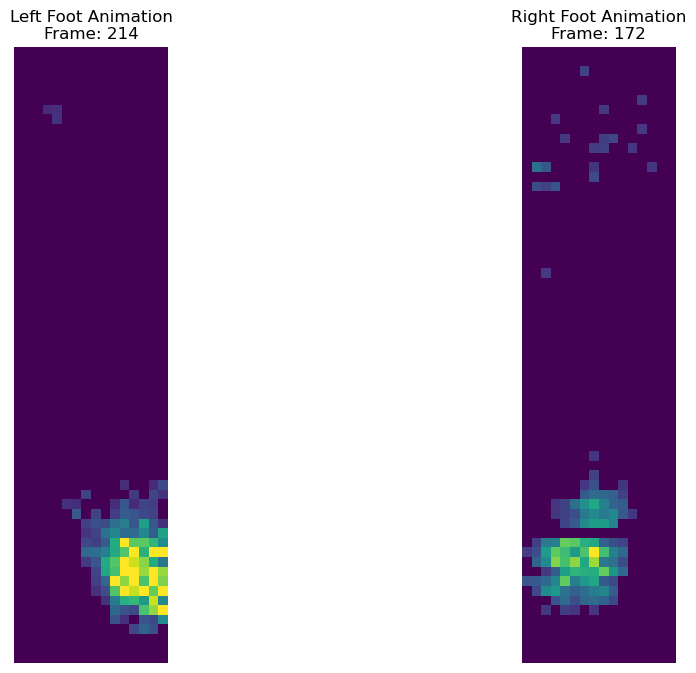

In [98]:
# Animate a single step to confirm segmentation
# Define thresholds for [h_th_r, t_th_r, h_th_l, t_th_l, strike_th_l, strike_th_r]
thresholds = [
    tunable_params['h_th_r'], tunable_params['t_th_r'], 
    tunable_params['h_th_l'], tunable_params['t_th_l'], 
    tunable_params['strike_th_l'], tunable_params['strike_th_r']
]

# Compute Gait Event Masks
gait_events = get_gait_event_masks(insoleAll_r, insoleAll_l, t_insole_r, t_insole_l, thresholds, dim=tunable_params['insole_dims'])

# For animation, select the first valid step for each foot.
selected_step_r = gait_events['steps_r'][0]
selected_step_l = gait_events['steps_l'][0]

# Extract step frames for right and left feet.
start_idx_r = selected_step_r['strike'][0]
off_idx_r = selected_step_r['off'][0] if selected_step_r['off'] else (selected_step_r['strike'][1] if len(selected_step_r['strike']) > 1 else start_idx_r)
step_frames_r = insoleAll_r[start_idx_r:off_idx_r+1, :]

start_idx_l = selected_step_l['strike'][0]
off_idx_l = selected_step_l['off'][0] if selected_step_l['off'] else (selected_step_l['strike'][1] if len(selected_step_l['strike']) > 1 else start_idx_l)
step_frames_l = insoleAll_l[start_idx_l:off_idx_l+1, :]

# --- Animation: Arrange so Left Foot is on the left and Right Foot is on the right ---
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 8))

# Left Foot Animation: only flip the top half.
init_frame_l = step_frames_l[0].reshape(tunable_params['insole_dims'], order='F')
init_frame_l[:32, :] = np.flipud(init_frame_l[:32, :])
im_l = ax_l.imshow(init_frame_l, cmap='viridis', interpolation='nearest')
ax_l.axis('off')
ax_l.set_title("Left Foot Animation\nFrame: {}".format(start_idx_l))

# Right Foot Animation: flip left-right then flip the top half.
init_frame_r = step_frames_r[0].reshape(tunable_params['insole_dims'], order='F')
init_frame_r = np.fliplr(init_frame_r)
init_frame_r[:32, :] = np.flipud(init_frame_r[:32, :])
im_r = ax_r.imshow(init_frame_r, cmap='viridis', interpolation='nearest')
ax_r.axis('off')
ax_r.set_title("Right Foot Animation\nFrame: {}".format(start_idx_r))

n_frames_r = step_frames_r.shape[0]
n_frames_l = step_frames_l.shape[0]
max_frames = max(n_frames_r, n_frames_l)

def update(frame_index):
    # Update Right Foot Animation (right subplot)
    idx_r = frame_index if frame_index < n_frames_r else n_frames_r - 1
    frame_data_r = step_frames_r[idx_r].reshape(tunable_params['insole_dims'], order='F')
    frame_data_r = np.fliplr(frame_data_r)
    frame_data_r[:32, :] = np.flipud(frame_data_r[:32, :])
    im_r.set_data(frame_data_r)
    ax_r.set_title(f"Right Foot Animation\nFrame: {start_idx_r + idx_r}")
    
    # Update Left Foot Animation (left subplot)
    idx_l = frame_index if frame_index < n_frames_l else n_frames_l - 1
    frame_data_l = step_frames_l[idx_l].reshape(tunable_params['insole_dims'], order='F')
    frame_data_l[:32, :] = np.flipud(frame_data_l[:32, :])
    im_l.set_data(frame_data_l)
    ax_l.set_title(f"Left Foot Animation\nFrame: {start_idx_l + idx_l}")
    
    return [im_l, im_r]

anim = animation.FuncAnimation(fig, update, frames=range(max_frames), interval=tunable_params['animation_interval'], blit=False)
HTML(anim.to_jshtml())

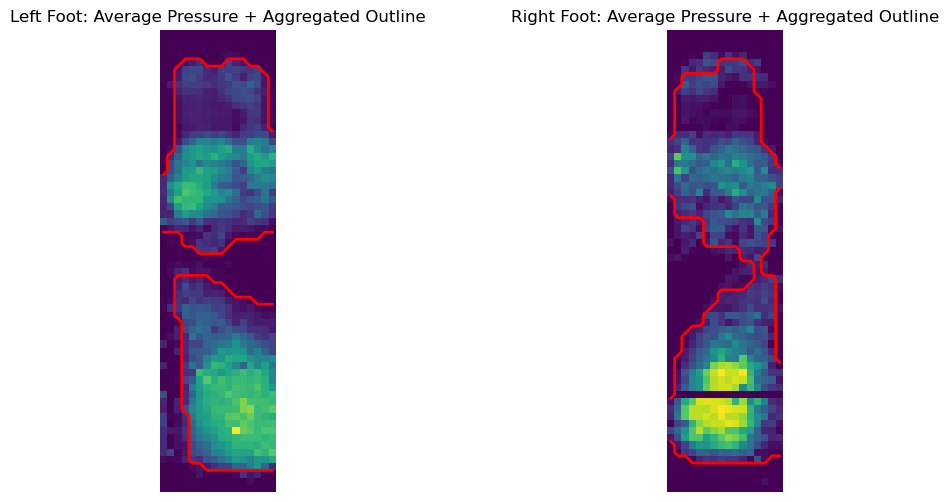

In [103]:
# Compute aggregated masks using a central window (± aggregation_window frames).
agg_mask_r = aggregate_mask_central_window(insoleAll_r, selected_step_r, dim=tunable_params['insole_dims'], window=tunable_params['aggregation_window'])
agg_mask_l = aggregate_mask_central_window(insoleAll_l, selected_step_l, dim=tunable_params['insole_dims'], window=tunable_params['aggregation_window'])
agg_mask_r = np.fliplr(agg_mask_r)

# Extract contours from the aggregated masks.
contours_r = find_contours(agg_mask_r, level=0.5)
contours_l = find_contours(agg_mask_l, level=0.5)

# Plot the aggregated outlines on the average pressure images.
fig, (ax_l, ax_r) = plt.subplots(1, 2, figsize=(12, 6))

# Left Foot Plot (left subplot)
ax_l.imshow(img_avg_l, cmap='viridis', interpolation='nearest')
for contour in contours_l:
    ax_l.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
ax_l.set_title("Left Foot: Average Pressure + Aggregated Outline")
ax_l.axis('off')

# Right Foot Plot (right subplot)
ax_r.imshow(img_avg_r, cmap='viridis', interpolation='nearest')
for contour in contours_r:
    ax_r.plot(contour[:, 1], contour[:, 0], 'r', linewidth=2)
ax_r.set_title("Right Foot: Average Pressure + Aggregated Outline")
ax_r.axis('off')

plt.show()

# Dividing by joints

## Drawing boundary lines

In [ ]:
# Helper function to rotate graphed line
def get_angled_line_coords(y_center, angle_deg, x_min=0, x_max=15, n_points=50):

    """
    Returns arrays of (x_vals, y_vals) in "image coordinates" for a line:
      - spanning from x_min to x_max
      - passing through (x_center, y_center) at the midpoint in x
      - tilted by angle_deg. (Positive angle = 'counterclockwise' in normal math.)
        However, note that in an imshow with origin='upper', the y-axis is inverted.
    """
    angle_rad = np.deg2rad(angle_deg)

    x_vals = np.linspace(x_min, x_max, n_points)
    slope = -np.tan(angle_rad)

    x_center = (x_min + x_max) / 2.0

    # Equation of the line in image coords: y = y_center + slope*(x - x_center)
    y_vals = y_center + slope * (x_vals - x_center)

    return x_vals, y_vals

Left foot length: 58
Right foot length 57


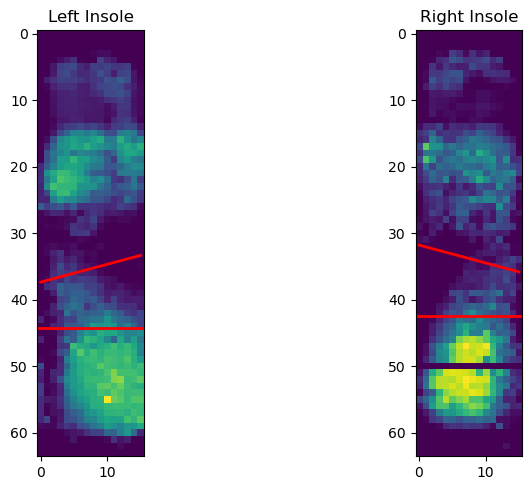

In [ ]:
# Set threshold for foot to create bounding box
threshold_l = 0.1 * np.max(img_avg_l)
threshold_r = 0.1 * np.max(img_avg_r)

mask_l = img_avg_l > threshold_l
mask_r = img_avg_r > threshold_r

rows_l, cols_l = np.where(mask_l)
rows_r, cols_r = np.where(mask_r)

foot_top_l, foot_bot_l = rows_l.min(), rows_l.max()
foot_top_r, foot_bot_r = rows_r.min(), rows_r.max()

foot_length_l = foot_bot_l - foot_top_l + 1
foot_length_r = foot_bot_r - foot_top_r + 1

print("Left foot length:", foot_length_l)
print("Right foot length", foot_length_r)

# Left foot lines
line1_l = foot_top_l + 0.54 * foot_length_l         # 54% from top
line2_l = foot_bot_l - 0.29 * foot_length_l       # 29% from bottom

# Right foot lines
line1_r = foot_top_r + 0.54 * foot_length_r
line2_r = foot_bot_r - 0.29 * foot_length_r

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Left Insole Plot
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")

# Right Insole Plot
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

# Left lines
angle_left = 15 # angle of rotation
xl1, yl1 = get_angled_line_coords(line1_l, angle_left, x_min=0, x_max=15, n_points=50)
axs[0].plot(xl1, yl1, color='r', linewidth=2)
axs[0].axhline(line2_l, color='r', linewidth=2)

# Right lines
angle_right = -15 # angle of rotation
xr1, yr1 = get_angled_line_coords(line1_r, angle_right, x_min=0, x_max=15, n_points=50)
axs[1].plot(xr1, yr1, color='r', linewidth=2)
axs[1].axhline(line2_r, color='r', linewidth=2)

plt.tight_layout()
plt.show()

## Assigning datapoints based on boundaries

In [ ]:
# Assign datapoints based on division above
forefoot_left_data  = []
midfoot_left_data   = []
hindfoot_left_data  = []

forefoot_right_data = []
midfoot_right_data  = []
hindfoot_right_data = []

# Precompute slopes for line1 left & right
slope_left  = -np.tan(np.deg2rad(angle_left))
slope_right = -np.tan(np.deg2rad(angle_right))
x_center = 7.5

N_left = insoleAll_l.shape[0]
N_right = insoleAll_r.shape[0]

for i in range(N_left):
    # Time for this left frame
    time_l_i = t_insole_l[i]
    # Reshape
    frame_l = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
    # Apply the same flipping as for the average:
    frame_l[:32, :] = np.flipud(frame_l[:32, :])
    
    # Classify each pixel
    for col in range(16):
        # The angled boundary for forefoot-midfoot at this column:
        boundary1_l_col = line1_l + slope_left * (col - x_center)
        for row in range(64):
            val = frame_l[row, col]
            if row < boundary1_l_col:
                # Forefoot
                forefoot_left_data.append([time_l_i, row, col, val])
            elif row < line2_l:
                # Midfoot
                midfoot_left_data.append([time_l_i, row, col, val])
            else:
                # Hindfoot
                hindfoot_left_data.append([time_l_i, row, col, val])

for i in range(N_right):
    # Time for this right frame
    time_r_i = t_insole_r[i]
    # Reshape
    frame_r = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
    # Flip right foot horizontally, plus top-half up-down
    frame_r = np.fliplr(frame_r)
    frame_r[:32, :] = np.flipud(frame_r[:32, :])
    
    # Classify each pixel
    for col in range(16):
        boundary1_r_col = line1_r + slope_right * (col - x_center)
        for row in range(64):
            val = frame_r[row, col]
            if row < boundary1_r_col:
                forefoot_right_data.append([time_r_i, row, col, val])
            elif row < line2_r:
                midfoot_right_data.append([time_r_i, row, col, val])
            else:
                hindfoot_right_data.append([time_r_i, row, col, val])


In [66]:
columns = ['timestamp', 'row', 'col', 'pressure']

forefoot_left_df  = pd.DataFrame(forefoot_left_data,  columns=columns)
midfoot_left_df   = pd.DataFrame(midfoot_left_data,   columns=columns)
hindfoot_left_df  = pd.DataFrame(hindfoot_left_data,  columns=columns)

forefoot_right_df = pd.DataFrame(forefoot_right_data, columns=columns)
midfoot_right_df  = pd.DataFrame(midfoot_right_data,  columns=columns)
hindfoot_right_df = pd.DataFrame(hindfoot_right_data, columns=columns)

forefoot_left_df['timestamp'] = forefoot_left_df['timestamp'].astype(np.float64)
midfoot_left_df['timestamp']  = midfoot_left_df['timestamp'].astype(np.float64)
hindfoot_left_df['timestamp'] = hindfoot_left_df['timestamp'].astype(np.float64)

forefoot_right_df['timestamp'] = forefoot_right_df['timestamp'].astype(np.float64)
midfoot_right_df['timestamp']  = midfoot_right_df['timestamp'].astype(np.float64)
hindfoot_right_df['timestamp'] = hindfoot_right_df['timestamp'].astype(np.float64)

forefoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_2/joint/forefoot_left.csv",  index=False)
midfoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_2/joint/midfoot_left.csv",    index=False)
hindfoot_left_df.to_csv("data_by_section/GAIT080624-01/walk_2/joint/hindfoot_left.csv",  index=False)

forefoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_2/joint/forefoot_right.csv", index=False)
midfoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_2/joint/midfoot_right.csv",   index=False)
hindfoot_right_df.to_csv("data_by_section/GAIT080624-01/walk_2/joint/hindfoot_right.csv", index=False)

In [67]:
# Visualize datapoint assignments
def build_color_foot_image(csv_fore: str,
                           csv_mid: str,
                           csv_hind: str,
                           region_colors: dict
                          ) -> np.ndarray:
    """
    Reads three CSV files (forefoot, midfoot, hindfoot) for a single foot,
    calculates the average pressure at each (row,col), and returns a
    color-coded 64 x 16 x 3 image where each region is drawn in a 
    distinct color and intensity is proportional to the average pressure.
    """

    # 1) Load each CSV
    df_fore = pd.read_csv(csv_fore)
    df_mid  = pd.read_csv(csv_mid)
    df_hind = pd.read_csv(csv_hind)

    # 2) Group by (row, col) => mean pressure
    group_fore = df_fore.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_mid  = df_mid.groupby(['row', 'col'])['pressure'].mean().reset_index()
    group_hind = df_hind.groupby(['row', 'col'])['pressure'].mean().reset_index()

    max_val = max(
        group_fore['pressure'].max(),
        group_mid['pressure'].max(),
        group_hind['pressure'].max()
    )

    # 4) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64, 16, 3), dtype=float)

    # Helper to fill in region
    def fill_region(df_group, color):
        for idx, row_data in df_group.iterrows():
            r   = int(row_data['row'])
            c   = int(row_data['col'])
            val = row_data['pressure']
            # Scale intensity by (val / max_val) so largest pressure ~ 1.0
            intensity = val / max_val
            foot_img[r, c, :] = color * intensity

    # 5) Fill each region with its color
    fill_region(group_fore, region_colors['fore'])
    fill_region(group_mid,  region_colors['mid'])
    fill_region(group_hind, region_colors['hind'])

    return foot_img

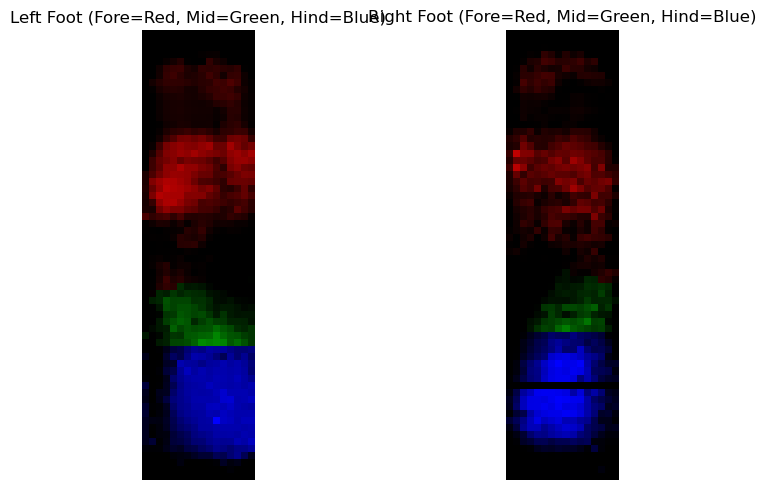

In [68]:
region_colors = {
    'fore': np.array([1.0, 0.0, 0.0]),  # Red
    'mid':  np.array([0.0, 1.0, 0.0]),  # Green
    'hind': np.array([0.0, 0.0, 1.0])   # Blue
}

# Build the color-coded images for left and right feet
foot_left_img = build_color_foot_image(
    'data_by_section/GAIT080624-01/walk_2/joint/forefoot_left.csv',
    'data_by_section/GAIT080624-01/walk_2/joint/midfoot_left.csv',
    'data_by_section/GAIT080624-01/walk_2/joint/hindfoot_left.csv',
    region_colors
)

foot_right_img = build_color_foot_image(
    'data_by_section/GAIT080624-01/walk_2/joint/forefoot_right.csv',
    'data_by_section/GAIT080624-01/walk_2/joint/midfoot_right.csv',
    'data_by_section/GAIT080624-01/walk_2/joint/hindfoot_right.csv',
    region_colors
)

# Plot side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title("Left Foot (Fore=Red, Mid=Green, Hind=Blue)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title("Right Foot (Fore=Red, Mid=Green, Hind=Blue)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Dividing by muscles

## Drawing boundary lines

In [70]:
# Helper functions to divide top and bottom by ratios
def get_extreme_points_top(rows, cols, foot_top, n=15):
    """
    Extracts the (x, y) coordinates of the left‑most and right‑most points
    in the top section defined by rows [foot_top, foot_top + n).
    """
    mask_top_section = (rows >= foot_top) & (rows < foot_top + n)
    front_rows = rows[mask_top_section]
    front_cols = cols[mask_top_section]
    
    leftmost_index = np.argmin(front_cols)
    leftmost_point = (front_cols[leftmost_index], front_rows[leftmost_index])
    
    rightmost_index = np.argmax(front_cols)
    rightmost_point = (front_cols[rightmost_index], front_rows[rightmost_index])
    
    return leftmost_point, rightmost_point

def get_extreme_points_bottom(rows, cols, foot_bottom, pressure_img, n=10, min_pressure=0.5):
    """
    Extracts the (x, y) coordinates of the left‑most and right‑most points
    in the bottom section defined by rows (foot_bottom - n, foot_bottom],
    but only considers points whose pressure (from pressure_img) is at least min_pressure.
    """
    mask_bottom_section = (rows <= foot_bottom) & (rows > foot_bottom - n)
    bottom_rows = rows[mask_bottom_section]
    bottom_cols = cols[mask_bottom_section]
    
    pressure_values = pressure_img[bottom_rows, bottom_cols]
    valid_mask = pressure_values >= min_pressure
    bottom_rows = bottom_rows[valid_mask]
    bottom_cols = bottom_cols[valid_mask]
    
    if len(bottom_rows) == 0:
        return None, None
    
    leftmost_index = np.argmin(bottom_cols)
    leftmost_point = (bottom_cols[leftmost_index], bottom_rows[leftmost_index])
    
    rightmost_index = np.argmax(bottom_cols)
    rightmost_point = (bottom_cols[rightmost_index], bottom_rows[rightmost_index])
    
    return leftmost_point, rightmost_point

def divide_line(A, B, t):
    """Returns the point along the line from A to B at fraction t."""
    return (A[0] + t * (B[0] - A[0]), A[1] + t * (B[1] - A[1]))

def shrink_line(A, B, shrink_factor=0.8):
    """
    Returns new endpoints for the line segment from A to B shrunk to shrink_factor times
    its original length, while keeping the segment centered.
    """
    M = ((A[0] + B[0]) / 2.0, (A[1] + B[1]) / 2.0)
    A_shrunk = (M[0] - (shrink_factor/2.0) * (B[0] - A[0]),
                M[1] - (shrink_factor/2.0) * (B[1] - A[1]))
    B_shrunk = (M[0] + (shrink_factor/2.0) * (B[0] - A[0]),
                M[1] + (shrink_factor/2.0) * (B[1] - A[1]))
    return A_shrunk, B_shrunk

def divide_bottom_line(foot_side, bot_left, bot_right):
    """
    For the bottom of the foot, using the extreme points bot_left and bot_right,
    first shrink the line connecting them to 80% of its original length.
    Then divide that shrunken line into segments in a 3.6:7:2 ratio.
    For the left foot, the division is applied from right to left;
    for the right foot, from left to right.
    
    Returns the two divider points.
    """
    if foot_side == "left":
        A = bot_right  # rightmost bottom point
        B = bot_left   # leftmost bottom point
    elif foot_side == "right":
        A = bot_left   # leftmost bottom point
        B = bot_right  # rightmost bottom point
    else:
        raise ValueError("foot_side must be either 'left' or 'right'")
    
    A_shrunk, B_shrunk = shrink_line(A, B, shrink_factor=0.8)
    total_parts = 3.6 + 7 + 2  # 12.6 parts
    t1 = 3.6 / total_parts      # ≈0.2857
    t2 = (3.6 + 7) / total_parts  # ≈0.8413
    
    div1 = divide_line(A_shrunk, B_shrunk, t1)
    div2 = divide_line(A_shrunk, B_shrunk, t2)
    
    return div1, div2

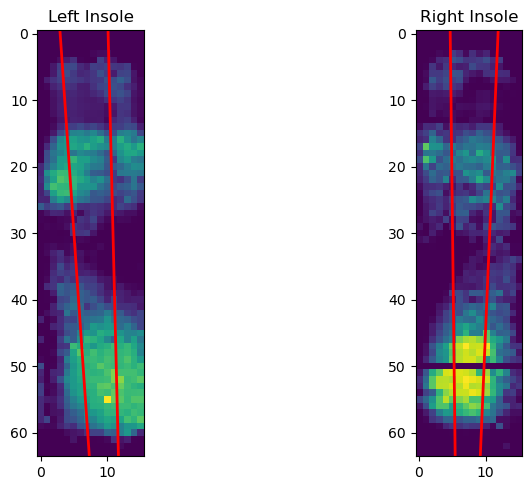

In [71]:
# Segmenting based on muscles (2:5:1)
# Get extreme top points
left_top_left, left_top_right = get_extreme_points_top(rows_l, cols_l, foot_top_l, n=10)
right_top_left, right_top_right = get_extreme_points_top(rows_r, cols_r, foot_top_r, n=10)

# Get extreme bottom points (with pressure filtering; adjust min_pressure as needed)
left_bot_left, left_bot_right = get_extreme_points_bottom(rows_l, cols_l, foot_bot_l, img_avg_l, n=10, min_pressure=300)
right_bot_left, right_bot_right = get_extreme_points_bottom(rows_r, cols_r, foot_bot_r, img_avg_r, n=10, min_pressure=300)

# Divide the top line using a 2:5:1 ratio
# For the right foot (division from left to right)
right_A_top = right_top_left
right_B_top = right_top_right
right_top_div1 = divide_line(right_A_top, right_B_top, 2/8)  # left divider point
right_top_div2 = divide_line(right_A_top, right_B_top, 7/8)  # right divider point
# For the left foot (division from right to left)
left_A_top = left_top_right
left_B_top = left_top_left
left_top_div1 = divide_line(left_A_top, left_B_top, 2/8)   # right divider point
left_top_div2 = divide_line(left_A_top, left_B_top, 7/8)   # left divider point

# Divide the bottom line using a 3.6:7:2 ratio (after shrinking)
# For the right foot (division from left to right)
right_bot_div1, right_bot_div2 = divide_bottom_line("right", right_bot_left, right_bot_right)
# For the left foot (division from right to left):
left_bot_div1, left_bot_div2 = divide_bottom_line("left", left_bot_left, left_bot_right)

# Draw two lines through each foot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img_avg_l)
axs[0].set_title("Left Insole")
axs[1].imshow(img_avg_r)
axs[1].set_title("Right Insole")

# Draw infinite red lines using ax.axline:
axs[0].axline(left_top_div2, left_bot_div2, color='r', linewidth=2)  # left side for left foot
axs[0].axline(left_top_div1, left_bot_div1, color='r', linewidth=2)  # right side for left foot

axs[1].axline(right_top_div1, right_bot_div1, color='r', linewidth=2)  # left side for right foot
axs[1].axline(right_top_div2, right_bot_div2, color='r', linewidth=2)  # right side for right foot

plt.tight_layout()
plt.show()

## Assigning datapoints based on boundaries

In [72]:
def side_of_line(ptA, ptB, ptP):
    """
    Returns the 2D cross product of (ptB - ptA) and (ptP - ptA).
    > 0 => ptP is to the "left" of the directed line A->B
    < 0 => ptP is to the "right" of A->B
    = 0 => ptP is exactly on the line
    """
    return ((ptB[0] - ptA[0]) * (ptP[1] - ptA[1])
          - (ptB[1] - ptA[1]) * (ptP[0] - ptA[0]))

In [ ]:
# LEFT FOOT lines:
Lline_left_top    = left_top_div2
Lline_left_bottom = left_bot_div2
Lline_right_top   = left_top_div1
Lline_right_bottom= left_bot_div1

# RIGHT FOOT lines:
Rline_left_top    = right_top_div1
Rline_left_bottom = right_bot_div1
Rline_right_top   = right_top_div2
Rline_right_bottom= right_bot_div2

left_foot_left_data   = []
left_foot_middle_data = []
left_foot_right_data  = []

right_foot_left_data   = []
right_foot_middle_data = []
right_foot_right_data  = []

# Get total frames
N_left  = insoleAll_l.shape[0]
N_right = insoleAll_r.shape[0]

# Loop over each time frame for the LEFT foot
for i in range(N_left):
    t_l_i = t_insole_l[i]  # Timestamp for this frame
    frame_l = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_l[row, col]
            P = (col, row)  # (x, y)
            
            side_left  = side_of_line(Lline_left_top, Lline_left_bottom, P)
            side_right = side_of_line(Lline_right_top, Lline_right_bottom, P)
            
            if side_left > 0:
                # Pixel is "left" of left boundary => left section
                left_foot_left_data.append([t_l_i, row, col, pressure_val])
            elif side_right < 0:
                # Pixel is "right" of right boundary => right section
                left_foot_right_data.append([t_l_i, row, col, pressure_val])
            else:
                # Otherwise, it's in the middle
                left_foot_middle_data.append([t_l_i, row, col, pressure_val])


# Loop over each time frame for the RIGHT foot
for i in range(N_right):
    t_r_i = t_insole_r[i]
    frame_r = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_r[row, col]
            P = (col, row)
            
            side_left  = side_of_line(Rline_left_top, Rline_left_bottom, P)
            side_right = side_of_line(Rline_right_top, Rline_right_bottom, P)
            
            if side_left > 0:
                right_foot_left_data.append([t_r_i, row, col, pressure_val])
            elif side_right < 0:
                right_foot_right_data.append([t_r_i, row, col, pressure_val])
            else:
                right_foot_middle_data.append([t_r_i, row, col, pressure_val])


In [74]:
cols = ["timestamp", "row", "col", "pressure"]

df_left_foot_left   = pd.DataFrame(left_foot_left_data,   columns=cols)
df_left_foot_middle = pd.DataFrame(left_foot_middle_data, columns=cols)
df_left_foot_right  = pd.DataFrame(left_foot_right_data,  columns=cols)

df_right_foot_left   = pd.DataFrame(right_foot_left_data,   columns=cols)
df_right_foot_middle = pd.DataFrame(right_foot_middle_data, columns=cols)
df_right_foot_right  = pd.DataFrame(right_foot_right_data,  columns=cols)

df_left_foot_left['timestamp']   = df_left_foot_left['timestamp'].astype('float64')
df_left_foot_middle['timestamp'] = df_left_foot_middle['timestamp'].astype('float64')
df_left_foot_right['timestamp']  = df_left_foot_right['timestamp'].astype('float64')

df_right_foot_left['timestamp']   = df_right_foot_left['timestamp'].astype('float64')
df_right_foot_middle['timestamp'] = df_right_foot_middle['timestamp'].astype('float64')
df_right_foot_right['timestamp']  = df_right_foot_right['timestamp'].astype('float64')

df_left_foot_left.to_csv("data_by_section/GAIT080624-01/walk_2/muscle/left_foot_left.csv", index=False)
df_left_foot_middle.to_csv("data_by_section/GAIT080624-01/walk_2/muscle/left_foot_middle.csv", index=False)
df_left_foot_right.to_csv("data_by_section/GAIT080624-01/walk_2/muscle/left_foot_right.csv", index=False)

df_right_foot_left.to_csv("data_by_section/GAIT080624-01/walk_2/muscle/right_foot_left.csv", index=False)
df_right_foot_middle.to_csv("data_by_section/GAIT080624-01/walk_2/muscle/right_foot_middle.csv", index=False)
df_right_foot_right.to_csv("data_by_section/GAIT080624-01/walk_2/muscle/right_foot_right.csv", index=False)

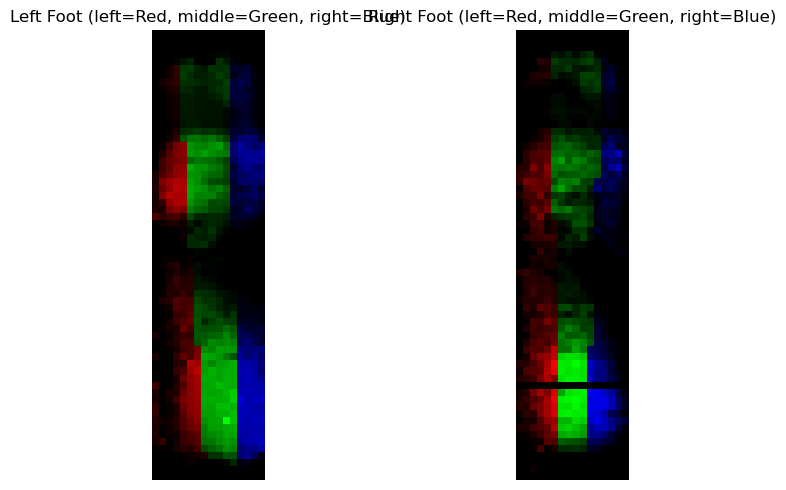

In [75]:
def build_color_foot_image(csv_left: str,
                           csv_middle: str,
                           csv_right: str,
                           region_colors: dict
                          ) -> np.ndarray:
    """
    Reads three CSV files (left, middle, right) for a single foot,
    calculates the average pressure at each (row,col), and returns a
    color-coded 64 x 16 x 3 image where each region is in a distinct color
    with intensity proportional to average pressure.
    """
    import pandas as pd
    import numpy as np

    # 1) Load each CSV
    df_left   = pd.read_csv(csv_left)
    df_middle = pd.read_csv(csv_middle)
    df_right  = pd.read_csv(csv_right)

    # 2) Group by (row, col) => mean pressure
    group_left   = df_left.groupby(['row','col'])['pressure'].mean().reset_index()
    group_middle = df_middle.groupby(['row','col'])['pressure'].mean().reset_index()
    group_right  = df_right.groupby(['row','col'])['pressure'].mean().reset_index()

    # 3) Determine a global max so we can scale intensities 0..1
    max_val = max(
        group_left['pressure'].max(),
        group_middle['pressure'].max(),
        group_right['pressure'].max()
    )

    # 4) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64,16,3), dtype=float)

    # Helper to fill region
    def fill_region(df_group, color):
        for _, row_data in df_group.iterrows():
            r   = int(row_data['row'])
            c   = int(row_data['col'])
            val = row_data['pressure']
            intensity = val / max_val
            foot_img[r, c, :] = color * intensity

    # 5) Fill each region with the color from region_colors
    fill_region(group_left,   region_colors['left'])    # Note the key 'left'
    fill_region(group_middle, region_colors['middle'])  # 'middle'
    fill_region(group_right,  region_colors['right'])   # 'right'

    return foot_img


region_colors = {
    'left': np.array([1.0, 0.0, 0.0]),  # Red
    'middle':  np.array([0.0, 1.0, 0.0]),  # Green
    'right': np.array([0.0, 0.0, 1.0])   # Blue
}

# Build the color-coded images for left and right feet
foot_left_img = build_color_foot_image(
    'data_by_section/GAIT080624-01/walk_2/muscle/left_foot_left.csv',
    'data_by_section/GAIT080624-01/walk_2/muscle/left_foot_middle.csv',
    'data_by_section/GAIT080624-01/walk_2/muscle/left_foot_right.csv',
    region_colors
)

foot_right_img = build_color_foot_image(
    'data_by_section/GAIT080624-01/walk_2/muscle/right_foot_left.csv',
    'data_by_section/GAIT080624-01/walk_2/muscle/right_foot_middle.csv',
    'data_by_section/GAIT080624-01/walk_2/muscle/right_foot_right.csv',
    region_colors
)

# Plot side by side
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title("Left Foot (left=Red, middle=Green, right=Blue)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title("Right Foot (left=Red, middle=Green, right=Blue)")
plt.axis('off')

plt.tight_layout()
plt.show()

# Dividing by nerves

## Drawing boundary lines

In [ ]:
# Helper functions for nerve distribution
def get_point_in_row(row_idx, foot_mask, fraction=0.25):
    """
    For the given row_idx, find all columns where foot_mask[row_idx, col] == True.
    Then return (x, y) = (col, row_idx) at the specified fraction
    between the leftmost and rightmost columns.
    Example: fraction=0.25 => 1:3 ratio from leftmost to rightmost.
    """
    cols_in_row = np.where(foot_mask[row_idx, :])[0]
    if len(cols_in_row) == 0:
        return None  # No foot data in this row

    leftmost = cols_in_row.min()
    rightmost = cols_in_row.max()

    # The fraction of the way from leftmost to rightmost
    x = leftmost + fraction * (rightmost - leftmost)
    return (x, row_idx)


def get_boundary_points(foot_side, foot_mask, foot_top, foot_bot):
    """
    Returns two points:
      p1 = 1:3 ratio in the '10th row' from the top
      p2 = midpoint (1:1) in the row at 5/8 of the height from top to bottom
    Invert the fraction for the 1:3 ratio if foot_side == 'right'.
    """
    # "10th row" from top (0-based means add 9)
    row_10 = foot_top + 9

    # 5/8 down from top
    row_5_8 = int(foot_top + (5/8)*(foot_bot - foot_top))

    # For left foot => fraction=0.25 (1:3 ratio from left to right)
    # For right foot => fraction=0.75 (inverted)
    if foot_side.lower() == "left":
        frac_1_3 = 0.25
    else:
        frac_1_3 = 0.75

    p1 = get_point_in_row(row_10, foot_mask, fraction=frac_1_3)
    # p2 = midpoint => fraction=0.5
    p2 = get_point_in_row(row_5_8, foot_mask, fraction=0.5)

    return p1, p2

def draw_line_one_sided(ax, p_start, p_end, color='r'):
    """
    Parametric form:
       p(t) = p_start + t*(d),  where d = (p_end - p_start).
    We want t from 0 to tmax, so p(0)=p_start, p(1)=p_end (inside line),
    and the line extends beyond t=1 until it hits boundary, but
    does NOT go below p(0).

    bounding box: x in [0,15], y in [0,63].
    """
    if p_start is None or p_end is None:
        return
    
    x0, y0 = p_start
    x1, y1 = p_end
    dx = x1 - x0
    dy = y1 - y0

    tmin, tmax = 0.0, float('inf')  # We'll keep t >= 0
    # handle x
    if abs(dx) > 1e-9:
        if dx > 0:
            # t in [ -x0/dx, (15 - x0)/dx ]
            left = -x0/dx
            right = (15 - x0)/dx
        else:
            # dx < 0
            left = (15 - x0)/dx
            right = -x0/dx
        # intersection with [0,∞):
        lower_bound = max(0, left)
        upper_bound = min(right, float('inf'))
        tmin = max(tmin, lower_bound)
        tmax = min(tmax, upper_bound)

    # handle y
    if abs(dy) > 1e-9:
        if dy > 0:
            # t in [ -y0/dy, (63 - y0)/dy ]
            left = -y0/dy
            right = (63 - y0)/dy
        else:
            # dy < 0
            left = (63 - y0)/dy
            right = -y0/dy
        # intersection with [0,∞)
        lower_bound = max(0, left)
        upper_bound = min(right, float('inf'))
        tmin = max(tmin, lower_bound)
        tmax = min(tmax, upper_bound)
    else:
        # dy=0 => no additional constraint on y
        pass

    if tmax < tmin:
        # no valid intersection; no line
        return
    
    # We'll draw from t=0 to t=tmax
    xA = x0 + tmin*dx
    yA = y0 + tmin*dy
    xB = x0 + tmax*dx
    yB = y0 + tmax*dy

    # Just to ensure we are inside the bounding box
    xA, yA = max(0, min(15, xA)), max(0, min(63, yA))
    xB, yB = max(0, min(15, xB)), max(0, min(63, yB))

    ax.plot([xA, xB], [yA, yB], color=color, linewidth=2)

def draw_45_deg_branches(ax, point, length=10, color='g'):
    """
    Draws two short 45° line segments ("V" shape) downward from 'point'.
    In row-column coords, "down" means increasing y.
    We'll define one branch with slope ~ +1, the other ~ -1.
    """
    x0, y0 = point

    # Left-branch: (x0 - length, y0 + length)
    x_left = x0 - length
    y_down_left = y0 + length

    # Right-branch: (x0 + length, y0 + length)
    x_right = x0 + length
    y_down_right = y0 + length

    ax.plot([x0, x_left], [y0, y_down_left], color=color, linewidth=2)
    ax.plot([x0, x_right], [y0, y_down_right], color=color, linewidth=2)

def get_45_end_right_edge(p2):
    """
    For slope = +1, param is:
       x(t) = x2 + t,   y(t) = y2 + t
    We solve for x(t)=15 => t = 15 - x2.
    Then y(t)=y2 + (15 - x2). If that exceeds 63, clamp y=63.
    Returns the intersection point (x_end, y_end).
    """
    x2, y2 = p2
    # Solve t = 15 - x2
    t = 15 - x2
    if t < 0:
        # Means p2 is already beyond the right edge or no valid intersection
        return None
    y_end = y2 + t
    # Clamp to y=63 if needed
    if y_end > 63:
        y_end = 63
    return (15, y_end)


def get_45_end_left_edge(p2):
    """
    For slope = -1, param is:
       x(t) = x2 - t,   y(t) = y2 + t
    We solve x(t)=0 => t = x2.
    Then y(t)=y2 + x2. If that exceeds 63, clamp y=63.
    Returns (0, y_end).
    """
    x2, y2 = p2
    t = x2
    if t < 0:
        # Means p2 is left of x=0 or no valid intersection
        return None
    y_end = y2 + t
    if y_end > 63:
        y_end = 63
    return (0, y_end)


def draw_curve(ax, start_pt, end_pt, shift, color='m'):
    """
    Draw a strongly curved line from start_pt to end_pt by adding
    a horizontal 'shift * t(1 - t)' term.
    - If 'shift' < 0, the curve bows left.
    - If 'shift' > 0, the curve bows right.
    """
    if (start_pt is None) or (end_pt is None):
        return
    x0, y0 = start_pt
    x1, y1 = end_pt
    
    t_vals = np.linspace(0, 1, 50)  # 50 points for smoother curve
    
    # x: linear interpolation plus a "shift * t*(1-t)" offset
    x_curve = (1 - t_vals)*x0 + t_vals*x1 + shift * t_vals*(1 - t_vals)
    # y: just linear interpolation
    y_curve = (1 - t_vals)*y0 + t_vals*y1
    
    ax.plot(x_curve, y_curve, color=color, linewidth=2)


In [26]:
# Creating mask of foot
pressure_threshold = 10

foot_mask_l = img_avg_l > pressure_threshold
foot_mask_r = img_avg_r > pressure_threshold

# Find the row/col indices of those nonzero foot mask pixels
rows_l, cols_l = np.nonzero(foot_mask_l)
rows_r, cols_r = np.nonzero(foot_mask_r)

# Find the topmost and bottommost row indices where the foot has data
foot_top_l = rows_l.min()
foot_bot_l = rows_l.max()
foot_top_r = rows_r.min()
foot_bot_r = rows_r.max()


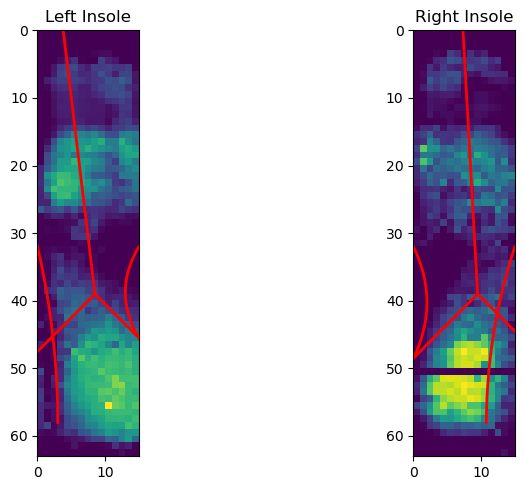

In [ ]:
# Segmenting by nerve distribution
left_p1, left_p2 = get_boundary_points("left", foot_mask_l, foot_top_l, foot_bot_l)
right_p1, right_p2 = get_boundary_points("right", foot_mask_r, foot_top_r, foot_bot_r)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10,5))

# Lateral and Medial Plantar nerves
# --- LEFT FOOT ---
axs[0].imshow(img_avg_l, origin='upper', cmap='viridis',
              extent=[0,16,64,0])   # so x=0..16, y=0..64 in display
axs[0].set_xlim(0,15)
axs[0].set_ylim(63,0)
axs[0].set_title("Left Insole")

# Line starts at p2, extends in the direction (p1 - p2)
if left_p1 and left_p2:
    # draw the half-infinite line from p2 to bounding box in direction p1
    draw_line_one_sided(axs[0], p_start=left_p2, p_end=left_p1, color='r')
    # show the points
    axs[0].plot(left_p1[0], left_p1[1], 'r')
    axs[0].plot(left_p2[0], left_p2[1], 'r')
    # from p2, draw the 45° branches
    draw_45_deg_branches(axs[0], left_p2, color='r')

# --- RIGHT FOOT ---
axs[1].imshow(img_avg_r, origin='upper', cmap='viridis',
              extent=[0,16,64,0])
axs[1].set_xlim(0,15)
axs[1].set_ylim(63,0)
axs[1].set_title("Right Insole")

if right_p1 and right_p2:
    draw_line_one_sided(axs[1], p_start=right_p2, p_end=right_p1, color='r')
    axs[1].plot(right_p1[0], right_p1[1], 'r')
    axs[1].plot(right_p2[0], right_p2[1], 'r')
    draw_45_deg_branches(axs[1], right_p2, color='r')

# Define new 'effective' bottom rows, 4 up from the actual foot_bot
foot_bot_eff_l = foot_bot_l - 4
foot_bot_eff_r = foot_bot_r - 4

# Safeguard in case foot_bot_eff < foot_top, etc.
if foot_bot_eff_l < foot_top_l:
    foot_bot_eff_l = foot_top_l
if foot_bot_eff_r < foot_top_r:
    foot_bot_eff_r = foot_top_r

# Sural nerve
# --- LEFT FOOT ---
row_mid_l = (foot_top_l + foot_bot_l) // 2  # same midpoint row
x_start_l = 0
y_start_l = row_mid_l

cols_bot_eff_l = np.where(foot_mask_l[foot_bot_eff_l, :])[0]
if len(cols_bot_eff_l) > 0:
    x_left_bot_l = cols_bot_eff_l.min()
    x_right_bot_l = cols_bot_eff_l.max()
    # 1/5 from the LEFT side => fraction=0.2
    x_target_l = x_left_bot_l + 0.2 * (x_right_bot_l - x_left_bot_l)

    t_vals = np.linspace(0, 1, 30)
    # "Bow inward" by using (1 - (1-t)^2) for x progression
    x_curve_l = x_start_l + (x_target_l - x_start_l) * (1 - (1 - t_vals)**2)
    # y is a simple linear interpolation from row_mid_l down to foot_bot_eff_l
    y_curve_l = y_start_l + (foot_bot_eff_l - y_start_l) * t_vals

    axs[0].plot(x_curve_l, y_curve_l, 'r-', linewidth=2)


# --- RIGHT FOOT ---
row_mid_r = (foot_top_r + foot_bot_r) // 2
x_start_r = 15
y_start_r = row_mid_r

cols_bot_eff_r = np.where(foot_mask_r[foot_bot_eff_r, :])[0]
if len(cols_bot_eff_r) > 0:
    x_left_bot_r = cols_bot_eff_r.min()
    x_right_bot_r = cols_bot_eff_r.max()
    # "1/5 from the right" => fraction=0.8 from the left edge
    x_target_r = x_left_bot_r + 0.8 * (x_right_bot_r - x_left_bot_r)

    t_vals = np.linspace(0, 1, 30)
    x_curve_r = x_start_r + (x_target_r - x_start_r) * (1 - (1 - t_vals)**2)
    y_curve_r = y_start_r + (foot_bot_eff_r - y_start_r) * t_vals

    axs[1].plot(x_curve_r, y_curve_r, 'r-', linewidth=2)

# Saphenous nerve
# --- LEFT FOOT ---
row_mid_l = (foot_top_l + foot_bot_l) // 2
p_start_l = (15, row_mid_l)               # e.g. right edge, midpoint row
p_end_l = get_45_end_right_edge(left_p2)  # intersection with x=15 from left_p2's +45 line

# Suppose "inward" is negative shift => let's pick shift=-10 for a big bend
draw_curve(axs[0], p_start_l, p_end_l, shift=-8, color='r')

# --- RIGHT FOOT ---
row_mid_r = (foot_top_r + foot_bot_r) // 2
p_start_r = (0, row_mid_r)                # left edge, midpoint row
p_end_r = get_45_end_left_edge(right_p2)  # intersection with x=0 from right_p2's -45 line

# For the right foot, "inward" might mean shifting to larger x => shift=+10
draw_curve(axs[1], p_start_r, p_end_r, shift=8, color='r')

plt.tight_layout()
plt.show()

## Assigning datapoints based on boundaries

In [30]:
# First, define y_end values based on the nerve curve endpoints:
p_end_l = get_45_end_right_edge(left_p2)   # for left foot
if p_end_l is not None:
    y_end_l = p_end_l[1]
else:
    y_end_l = foot_bot_eff_l

p_end_r = get_45_end_left_edge(right_p2)   # for right foot
if p_end_r is not None:
    y_end_r = p_end_r[1]
else:
    y_end_r = foot_bot_eff_r

In [ ]:
# --- LEFT FOOT SEGMENTATION ---
left_foot_lateral_plantar_data = []  # lateral plantar
left_foot_medial_plantar_data   = []  # medial plantar
left_foot_tibial_data           = []  # tibial
left_foot_sural_data            = []  # sural
left_foot_saphenous_data        = []  # saphenous

N_left = insoleAll_l.shape[0]

for i in range(N_left):
    t_l = t_insole_l[i]  # timestamp for this frame
    # Reshape the flat vector into a 64x16 image (order='F')
    frame_l = np.reshape(insoleAll_l[i, :], (64, 16), order='F')
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_l[row, col]
            # Optionally skip low-pressure readings:
            if pressure_val < pressure_threshold:
                continue
            P = (col, row)  # (x, y)
            # --- Step 1: Dividing line ---
            # For left foot, a sensor is considered "lateral" if it lies to the left of the line from p2 to p1.
            side_div = side_of_line(left_p2, left_p1, P)
            
            # --- Step 2: 45° branch lines (from left_p2) ---
            y_left_branch  = -col + (left_p2[0] + left_p2[1])
            y_right_branch =  col + (left_p2[1] - left_p2[0])
            
            # --- Step 3: Decide if sensor is in the "upper" (plantar) region ---
            if (row < y_left_branch) and (row < y_right_branch):
                # Sensor is above both branches.
                if side_div > 0:
                    # Candidate for lateral plantar.
                    if (row >= row_mid_l) and (row <= foot_bot_eff_l):
                        t_val = (row - row_mid_l) / (foot_bot_eff_l - row_mid_l)
                        # Sural nerve curve runs from left edge (x=0) toward x_target_l.
                        x_sural = (x_target_l) * (1 - (1 - t_val)**2)
                        if col > x_sural:
                            region = "lateral plantar"
                        else:
                            region = None
                    else:
                        region = "lateral plantar"
                elif side_div < 0:
                    # Candidate for medial plantar.
                    if (row >= row_mid_l) and (row <= y_end_l):
                        t_val = (row - row_mid_l) / (y_end_l - row_mid_l)
                        # Saphenous nerve curve runs from right edge (x=15) inward.
                        x_saph = 15 - 8 * t_val * (1 - t_val)
                        if col < x_saph:
                            region = "medial plantar"
                        else:
                            region = None
                    else:
                        region = "medial plantar"
                else:
                    region = None
            else:
                # --- Step 4: Lower region ---
                if (row >= row_mid_l) and (row <= foot_bot_eff_l):
                    t_val = (row - row_mid_l) / (foot_bot_eff_l - row_mid_l)
                    x_sural = (x_target_l) * (1 - (1 - t_val)**2)
                else:
                    x_sural = -np.inf
                if (row >= row_mid_l) and (row <= y_end_l):
                    t_val = (row - row_mid_l) / (y_end_l - row_mid_l)
                    x_saph = 15 - 8 * t_val * (1 - t_val)
                else:
                    x_saph = np.inf
                
                if col < x_sural:
                    region = "sural"
                elif col > x_saph:
                    region = "saphenous"
                else:
                    region = "tibial"
            
            # --- Step 5: Append sensor reading to the corresponding list ---
            if region == "lateral plantar":
                left_foot_lateral_plantar_data.append([t_l, row, col, pressure_val])
            elif region == "medial plantar":
                left_foot_medial_plantar_data.append([t_l, row, col, pressure_val])
            elif region == "tibial":
                left_foot_tibial_data.append([t_l, row, col, pressure_val])
            elif region == "sural":
                left_foot_sural_data.append([t_l, row, col, pressure_val])
            elif region == "saphenous":
                left_foot_saphenous_data.append([t_l, row, col, pressure_val])
            # If region is None, the sensor is not assigned.

# --- RIGHT FOOT SEGMENTATION ---
# For the right foot note: if you flipped the image, lateral/medial roles swap.
right_foot_lateral_plantar_data = []  # anatomically lateral (right)
right_foot_medial_plantar_data   = []  # anatomically medial (left)
right_foot_tibial_data           = []
right_foot_sural_data            = []
right_foot_saphenous_data        = []

N_right = insoleAll_r.shape[0]

for i in range(N_right):
    t_r = t_insole_r[i]
    frame_r = np.reshape(insoleAll_r[i, :], (64, 16), order='F')
    
    for row in range(64):
        for col in range(16):
            pressure_val = frame_r[row, col]
            if pressure_val < pressure_threshold:
                continue
            P = (col, row)
            # Use right_p2 and right_p1 for the dividing line.
            side_div = side_of_line(right_p2, right_p1, P)
            # 45° branch lines (from right_p2):
            y_left_branch  = -col + (right_p2[0] + right_p2[1])
            y_right_branch =  col + (right_p2[1] - right_p2[0])
            
            if (row < y_left_branch) and (row < y_right_branch):
                # Upper region.
                # For right foot, if image was flipped, the assignment is swapped:
                if side_div > 0:
                    # Sensor is to the left of dividing line → candidate for medial plantar.
                    if (row >= row_mid_r) and (row <= y_end_r):
                        t_val = (row - row_mid_r) / (y_end_r - row_mid_r)
                        x_saph = 15 - 8 * t_val * (1 - t_val)
                        if col < x_saph:
                            region = "medial plantar"
                        else:
                            region = None
                    else:
                        region = "medial plantar"
                elif side_div < 0:
                    # Sensor is to the right → candidate for lateral plantar.
                    if (row >= row_mid_r) and (row <= foot_bot_eff_r):
                        t_val = (row - row_mid_r) / (foot_bot_eff_r - row_mid_r)
                        # For right foot, sural nerve curve runs from right edge (x=15) inward.
                        x_sural = 15 + (x_target_r - 15) * (1 - (1 - t_val)**2)
                        if col > x_sural:
                            region = "lateral plantar"
                        else:
                            region = None
                    else:
                        region = "lateral plantar"
                else:
                    region = None
            else:
                # Lower region.
                if (row >= row_mid_r) and (row <= foot_bot_eff_r):
                    t_val = (row - row_mid_r) / (foot_bot_eff_r - row_mid_r)
                    x_sural = 15 + (x_target_r - 15) * (1 - (1 - t_val)**2)
                else:
                    x_sural = np.inf
                if (row >= row_mid_r) and (row <= y_end_r):
                    t_val = (row - row_mid_r) / (y_end_r - row_mid_r)
                    x_saph = 0 + 8 * t_val * (1 - t_val)
                else:
                    x_saph = -np.inf
                
                if col > x_sural:
                    region = "sural"
                elif col < x_saph:
                    region = "saphenous"
                else:
                    region = "tibial"
            
            if region == "lateral plantar":
                right_foot_lateral_plantar_data.append([t_r, row, col, pressure_val])
            elif region == "medial plantar":
                right_foot_medial_plantar_data.append([t_r, row, col, pressure_val])
            elif region == "tibial":
                right_foot_tibial_data.append([t_r, row, col, pressure_val])
            elif region == "sural":
                right_foot_sural_data.append([t_r, row, col, pressure_val])
            elif region == "saphenous":
                right_foot_saphenous_data.append([t_r, row, col, pressure_val])

In [ ]:
cols = ["timestamp", "row", "col", "pressure"]

# Left foot CSVs:
df_left_lateral   = pd.DataFrame(left_foot_lateral_plantar_data, columns=cols)
df_left_medial    = pd.DataFrame(left_foot_medial_plantar_data,   columns=cols)
df_left_tibial    = pd.DataFrame(left_foot_tibial_data,           columns=cols)
df_left_sural     = pd.DataFrame(left_foot_sural_data,            columns=cols)
df_left_saphenous = pd.DataFrame(left_foot_saphenous_data,        columns=cols)

df_left_lateral['timestamp']   = df_left_lateral['timestamp'].astype('float64')
df_left_medial['timestamp']    = df_left_medial['timestamp'].astype('float64')
df_left_tibial['timestamp']    = df_left_tibial['timestamp'].astype('float64')
df_left_sural['timestamp']     = df_left_sural['timestamp'].astype('float64')
df_left_saphenous['timestamp'] = df_left_saphenous['timestamp'].astype('float64')

df_left_lateral.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/left_foot_lateral_plantar.csv", index=False)
df_left_medial.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/left_foot_medial_plantar.csv", index=False)
df_left_tibial.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/left_foot_tibial.csv", index=False)
df_left_sural.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/left_foot_sural.csv", index=False)
df_left_saphenous.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/left_foot_saphenous.csv", index=False)

# Right foot CSVs:
df_right_lateral   = pd.DataFrame(right_foot_lateral_plantar_data, columns=cols)
df_right_medial    = pd.DataFrame(right_foot_medial_plantar_data,   columns=cols)
df_right_tibial    = pd.DataFrame(right_foot_tibial_data,           columns=cols)
df_right_sural     = pd.DataFrame(right_foot_sural_data,            columns=cols)
df_right_saphenous = pd.DataFrame(right_foot_saphenous_data,        columns=cols)

df_right_lateral['timestamp']   = df_right_lateral['timestamp'].astype('float64')
df_right_medial['timestamp']    = df_right_medial['timestamp'].astype('float64')
df_right_tibial['timestamp']    = df_right_tibial['timestamp'].astype('float64')
df_right_sural['timestamp']     = df_right_sural['timestamp'].astype('float64')
df_right_saphenous['timestamp'] = df_right_saphenous['timestamp'].astype('float64')

df_right_lateral.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/right_foot_lateral_plantar.csv", index=False)
df_right_medial.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/right_foot_medial_plantar.csv", index=False)
df_right_tibial.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/right_foot_tibial.csv", index=False)
df_right_sural.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/right_foot_sural.csv", index=False)
df_right_saphenous.to_csv("data_by_section/GAIT080624-01/walk_2/nerve/right_foot_saphenous.csv", index=False)

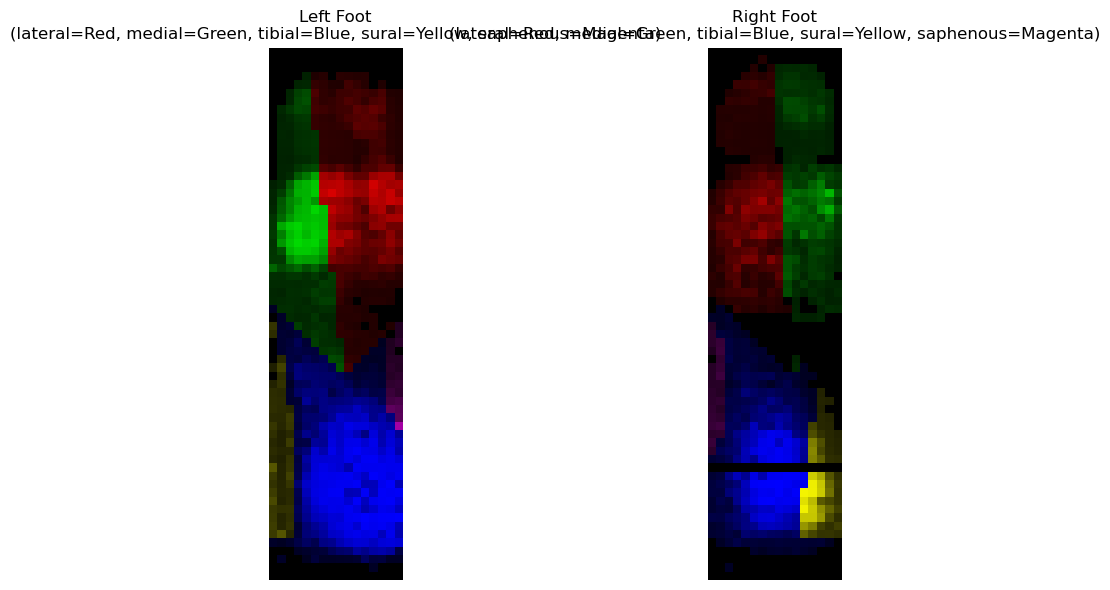

In [ ]:
def build_color_foot_image(csv_lateral: str,
                           csv_medial: str,
                           csv_tibial: str,
                           csv_sural: str,
                           csv_saphenous: str,
                           region_colors: dict) -> np.ndarray:
    """
    Reads five CSV files for a single foot (for the five regions: lateral plantar,
    medial plantar, tibial, sural, and saphenous), calculates the average pressure at each (row, col),
    and returns a color-coded 64 x 16 x 3 image where each region is filled with a distinct color
    scaled by the average pressure intensity.
    """
    import pandas as pd
    import numpy as np

    # 1) Load each CSV
    df_lateral   = pd.read_csv(csv_lateral)
    df_medial    = pd.read_csv(csv_medial)
    df_tibial    = pd.read_csv(csv_tibial)
    df_sural     = pd.read_csv(csv_sural)
    df_saphenous = pd.read_csv(csv_saphenous)

    # 2) Group by (row, col) and compute mean pressure for each region
    group_lateral   = df_lateral.groupby(['row','col'])['pressure'].mean().reset_index()
    group_medial    = df_medial.groupby(['row','col'])['pressure'].mean().reset_index()
    group_tibial    = df_tibial.groupby(['row','col'])['pressure'].mean().reset_index()
    group_sural     = df_sural.groupby(['row','col'])['pressure'].mean().reset_index()
    group_saphenous = df_saphenous.groupby(['row','col'])['pressure'].mean().reset_index()

    # 3) Determine a global max pressure so intensities can be scaled 0..1
    max_val = max(
        group_lateral['pressure'].max(),
        group_medial['pressure'].max(),
        group_tibial['pressure'].max(),
        group_sural['pressure'].max(),
        group_saphenous['pressure'].max()
    )

    # 4) Build an empty color image (64 x 16 x 3)
    foot_img = np.zeros((64,16,3), dtype=float)

    # Helper: Fill a region in the image with a given color scaled by intensity
    def fill_region(df_group, color):
        for _, row_data in df_group.iterrows():
            r   = int(row_data['row'])
            c   = int(row_data['col'])
            val = row_data['pressure']
            intensity = val / max_val
            foot_img[r, c, :] = color * intensity

    # 5) Fill each region using its assigned color
    fill_region(group_lateral,   region_colors['lateral'])
    fill_region(group_medial,    region_colors['medial'])
    fill_region(group_tibial,    region_colors['tibial'])
    fill_region(group_sural,     region_colors['sural'])
    fill_region(group_saphenous, region_colors['saphenous'])

    return foot_img


# Define colors for the five regions.
region_colors = {
    'lateral':   np.array([1.0, 0.0, 0.0]),  # Red for lateral plantar
    'medial':    np.array([0.0, 1.0, 0.0]),  # Green for medial plantar
    'tibial':    np.array([0.0, 0.0, 1.0]),  # Blue for tibial
    'sural':     np.array([1.0, 1.0, 0.0]),  # Yellow for sural
    'saphenous': np.array([1.0, 0.0, 1.0])   # Magenta for saphenous
}

# Build the color-coded images for left and right feet.
foot_left_img = build_color_foot_image(
    'data_by_section/GAIT080624-01/walk_2/nerve/left_foot_lateral_plantar.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/left_foot_medial_plantar.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/left_foot_tibial.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/left_foot_sural.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/left_foot_saphenous.csv',
    region_colors
)

foot_right_img = build_color_foot_image(
    'data_by_section/GAIT080624-01/walk_2/nerve/right_foot_lateral_plantar.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/right_foot_medial_plantar.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/right_foot_tibial.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/right_foot_sural.csv',
    'data_by_section/GAIT080624-01/walk_2/nerve/right_foot_saphenous.csv',
    region_colors
)

# Plot the color-coded images side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(foot_left_img, origin='upper')
plt.title("Left Foot\n(lateral=Red, medial=Green, tibial=Blue, sural=Yellow, saphenous=Magenta)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(foot_right_img, origin='upper')
plt.title("Right Foot\n(lateral=Red, medial=Green, tibial=Blue, sural=Yellow, saphenous=Magenta)")
plt.axis('off')

plt.tight_layout()
plt.show()